In [1]:
#Load libraries and custom code to load events
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from ift6758.data import load_events_dataframe

Found 85939 events


# Choose the season for which you want to plot the data (example here is 2018)

In [ ]:
season = 2018
data = load_events_dataframe(season)

# Plot a barplot with the counts for each shot type and its associated success rate (goals)

/tmp/ipykernel_5000/702064577.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  goal.set_xticklabels(new_labels)


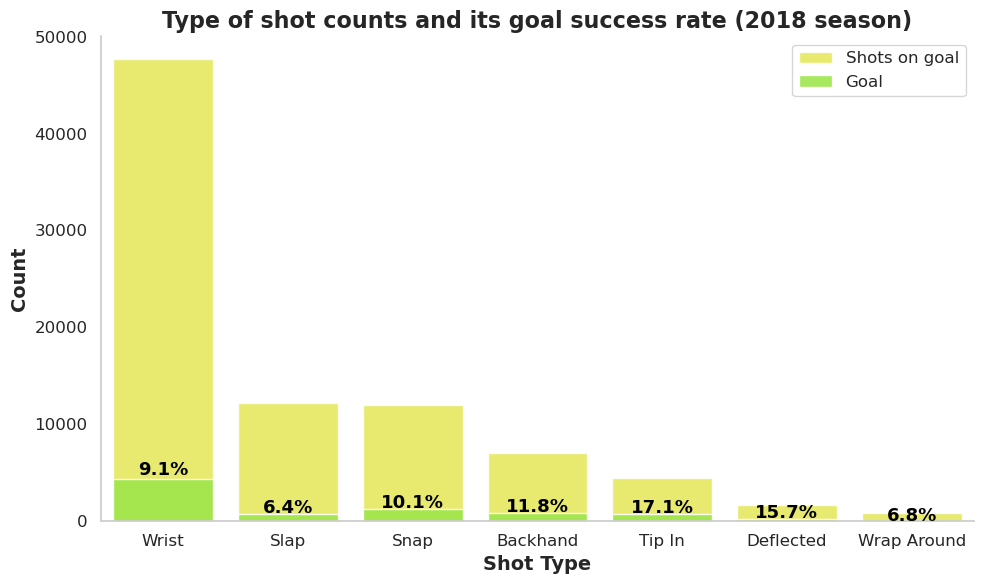

In [37]:
#Put decreasing order for shot_type
order = data['shot_type'].value_counts().index

#Plot size
plt.figure(figsize=(10, 6))

#Customized colors
sns.set(style="whitegrid")
sns.countplot(data=data, x='shot_type', order=order, color= '#fcff32', alpha=0.8, label='Shots on goal')
goal = sns.countplot(data=data[data.type_desc_key == 'goal'], x='shot_type', order=order, color='#9fff33' , alpha=0.9, label = 'Goal')

#Calculate success rate
shots = data.groupby('shot_type').size()
goals = data[data.type_desc_key == 'goal'].groupby('shot_type').size()
success_rate = (goals / shots) * 100  

#Add success rate
for i, shot in enumerate(order):
    goal_height = goals.get(shot, 0)
    percentage = success_rate.get(shot, 0)
    
    #Add text with percentage at the top of the goal count
    goal.text(i, goal_height * 1.10, f'{percentage:.1f}%', 
            ha='center', color='black', fontsize=13, fontweight='bold')

#Format and aesthetics
sns.despine()
goal.set_xlabel('Shot Type', fontsize=14, fontweight='bold')
goal.set_ylabel('Count', fontsize=14, fontweight='bold')
goal.grid(False)
new_labels = [label.replace('-', ' ').title() for label in order]
goal.set_xticklabels(new_labels)
goal.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
title = 'Type of shot counts and its goal success rate ('+str(season)+' season)'
plt.title(title, fontsize=16, fontweight='bold')
plt.legend(loc="upper right", fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()


# Barplot with success rate in function of distance 

/tmp/ipykernel_5000/1465032983.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shots_per_bin = data.groupby('distance_bin').size()
/tmp/ipykernel_5000/1465032983.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goals_per_bin = data[data.type_desc_key == 'goal'].groupby('distance_bin').size()


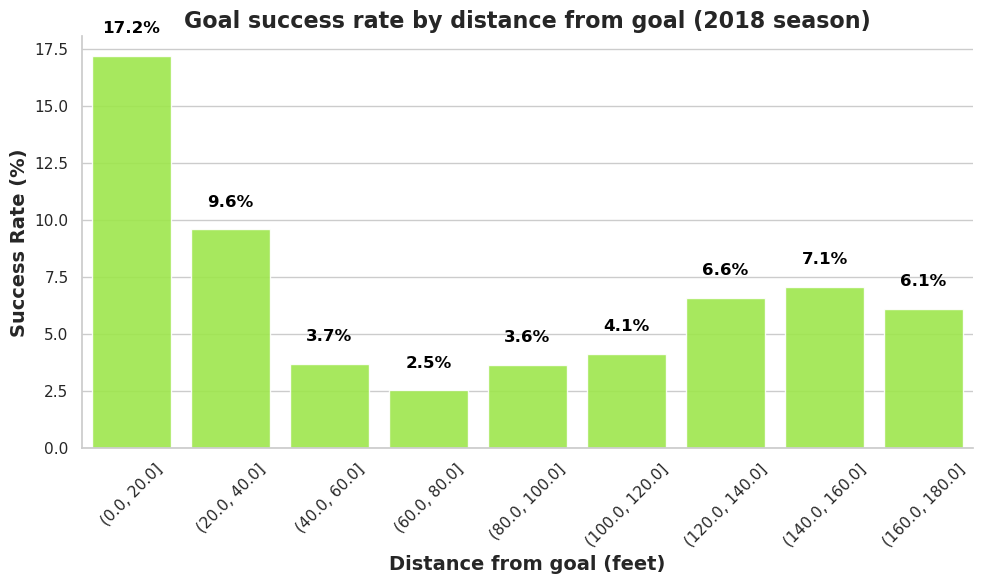

In [35]:
#Define the distance bins size
distance_bins = np.arange(0, max(data['goal_distance'])+1, 20) 

#Separate data according to bins
data['distance_bin'] = pd.cut(data['goal_distance'], bins=distance_bins)

#Calculate the number of shots and goals per bin
shots_per_bin = data.groupby('distance_bin').size()
goals_per_bin = data[data.type_desc_key == 'goal'].groupby('distance_bin').size()

#Calculate the success rate
success_rate_per_bin = (goals_per_bin / shots_per_bin) * 100
success_rate_per_bin = success_rate_per_bin.fillna(0)  # Fill Nas with 0

#Plot success rate as histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=success_rate_per_bin.index.astype(str), y=success_rate_per_bin.values, color='#9fff33', alpha=0.9)

#Add average success rate text
for i, rate in enumerate(success_rate_per_bin):
    plt.text(i, rate + 1, f'{rate:.1f}%', ha='center', color='black', fontsize=12, fontweight='bold')

#Format and aesthetics
title = 'Goal success rate by distance from goal (' + str(season) + ' season)'
plt.title(title, fontsize=16, fontweight='bold')
plt.xlabel('Distance from goal (feet)', fontsize=14, fontweight='bold')
plt.ylabel('Success Rate (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.show()

# Combined barplot with success rate percentage in function of distance and per shot type

/tmp/ipykernel_5000/707693254.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shots_per_bin_type = data_grouped.groupby(['distance_bin', 'shot_type']).size().reset_index(name='shots')
/tmp/ipykernel_5000/707693254.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goals_per_bin_type = data_grouped[data_grouped['success']].groupby(['distance_bin', 'shot_type']).size().reset_index(name='goals')


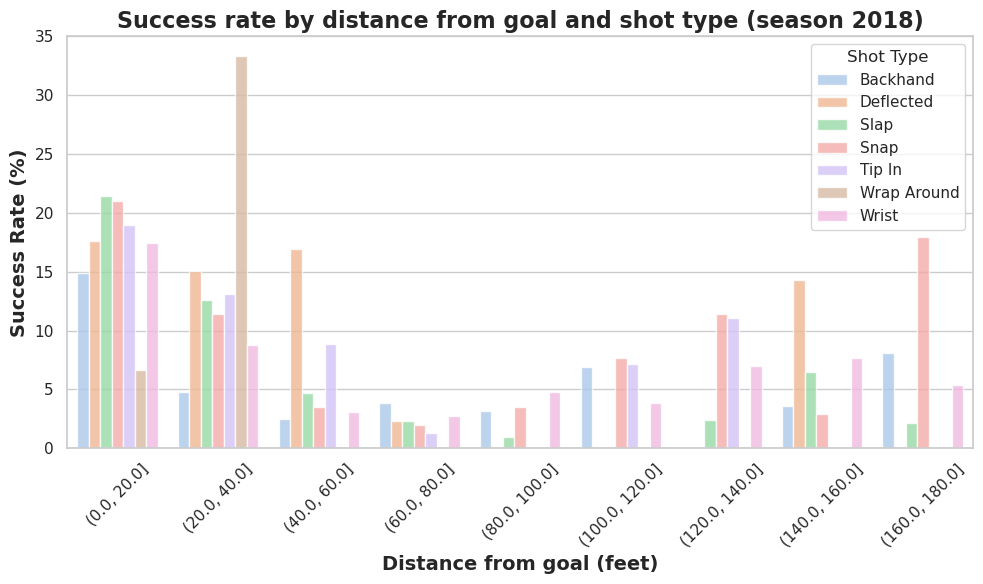

In [38]:
#Define the distance bins size
distance_bins = np.arange(0, max(data['goal_distance']) + 1, 20)

#Separate data according to bins
data['distance_bin'] = pd.cut(data['goal_distance'], bins=distance_bins)

#Filter the relevant shot types and calculate success
data_grouped = data[data['type_desc_key'].isin(['shot-on-goal', 'goal'])]
data_grouped['success'] = data_grouped['type_desc_key'] == 'goal'

#Group by distance bin and shot type to calculate total shots and goals
shots_per_bin_type = data_grouped.groupby(['distance_bin', 'shot_type']).size().reset_index(name='shots')
goals_per_bin_type = data_grouped[data_grouped['success']].groupby(['distance_bin', 'shot_type']).size().reset_index(name='goals')

#Merge shots and goals data into new dataframe
bin_type_stats = pd.merge(shots_per_bin_type, goals_per_bin_type, on=['distance_bin', 'shot_type'], how='left')

#Fill NAs in the 'goals' column with 0 (for bins with no goals)
bin_type_stats['goals'] = bin_type_stats['goals'].fillna(0)

#Calculate the success rate
bin_type_stats['success_rate'] = (bin_type_stats['goals'] / bin_type_stats['shots']) * 100
bin_type_stats['success_rate'] = bin_type_stats['success_rate'].fillna(0)  # Avoid NAs

#Format shot_type names
bin_type_stats['shot_type'] = bin_type_stats['shot_type'].str.replace('_', ' ').str.replace('-', ' ').str.title()

#Plot combined histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=bin_type_stats, x='distance_bin', y='success_rate', hue='shot_type', palette='pastel', alpha=0.8)

#Aesthetics and readibility improvements
plt.xlabel("Distance from goal (feet)", fontsize=14, fontweight = 'bold')
plt.ylabel('Success Rate (%)', fontsize=14, fontweight='bold')
title = "Success rate by distance from goal and shot type (season "+str(season)+")"
plt.title(title, fontsize = 16, fontweight = 'bold')
plt.legend(title='Shot Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Piled barplots with success rate percentage in function of distance for each shot type

/tmp/ipykernel_5000/1407657695.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shots_per_bin_type = data_grouped.groupby(['distance_bin', 'shot_type']).size().reset_index(name='shots')
/tmp/ipykernel_5000/1407657695.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goals_per_bin_type = data_grouped[data_grouped['success']].groupby(['distance_bin', 'shot_type']).size().reset_index(name='goals')
/home/thibault-maumy/miniconda3/envs/ift6758-project/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plo

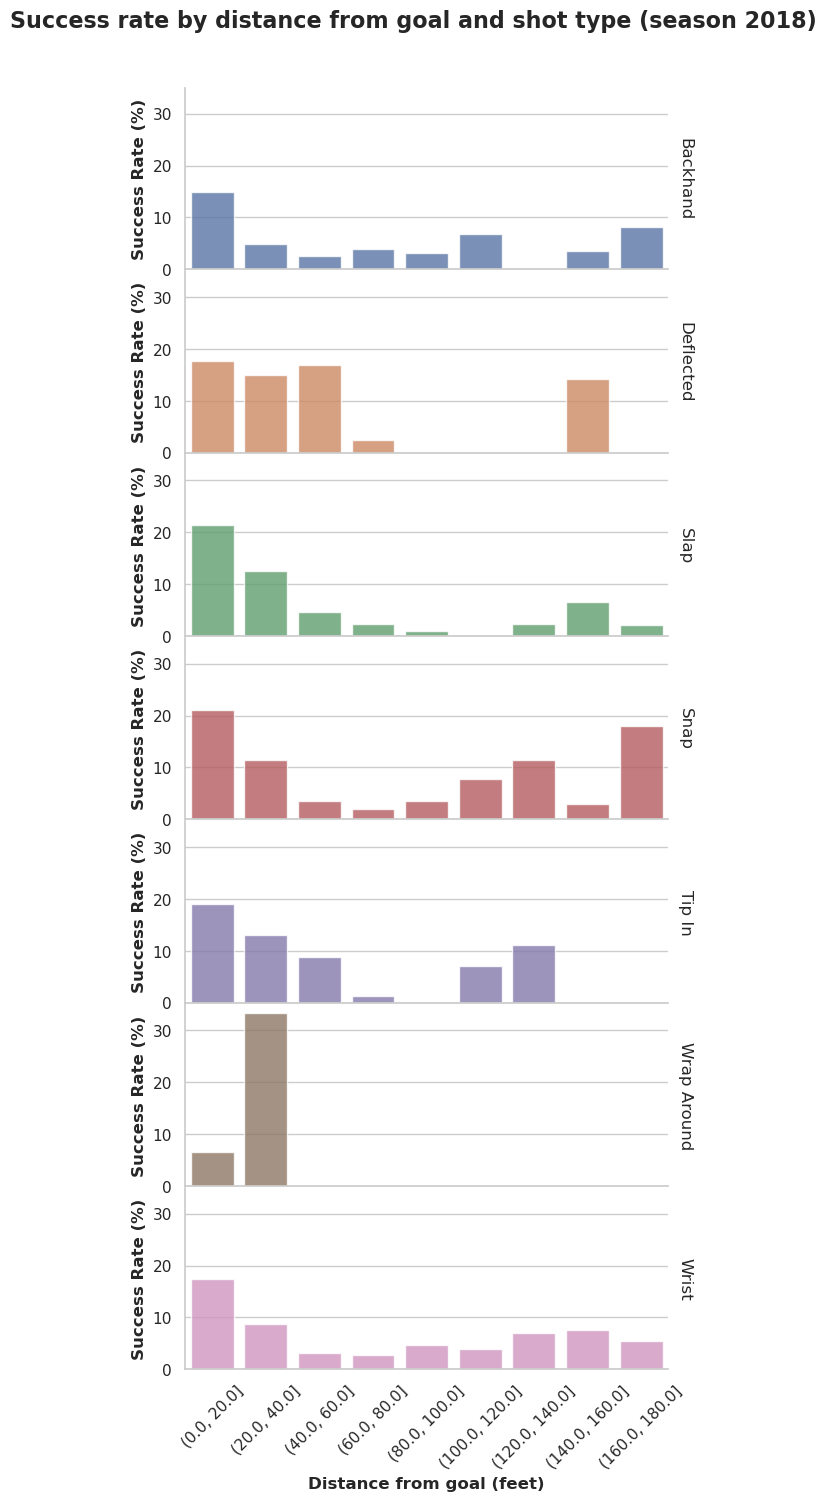

In [39]:
#Define the distance bins size
distance_bins = np.arange(0, max(data['goal_distance']) + 1, 20)

#Separate data according to bins
data['distance_bin'] = pd.cut(data['goal_distance'], bins=distance_bins)

#Filter the relevant shot types and calculate success
data_grouped = data[data['type_desc_key'].isin(['shot-on-goal', 'goal'])]
data_grouped['success'] = data_grouped['type_desc_key'] == 'goal'

#Group by distance bin and shot type to calculate total shots and goals
shots_per_bin_type = data_grouped.groupby(['distance_bin', 'shot_type']).size().reset_index(name='shots')
goals_per_bin_type = data_grouped[data_grouped['success']].groupby(['distance_bin', 'shot_type']).size().reset_index(name='goals')

#Merge shots and goals data into new dataframe
bin_type_stats = pd.merge(shots_per_bin_type, goals_per_bin_type, on=['distance_bin', 'shot_type'], how='left')

#Fill NAs in the 'goals' column with 0 (for bins with no goals)
bin_type_stats['goals'] = bin_type_stats['goals'].fillna(0)

#Calculate the success rate
bin_type_stats['success_rate'] = (bin_type_stats['goals'] / bin_type_stats['shots']) * 100
bin_type_stats['success_rate'] = bin_type_stats['success_rate'].fillna(0)  # Avoid NAs

#Format shot_type names
bin_type_stats['shot_type'] = bin_type_stats['shot_type'].str.replace('_', ' ').str.replace('-', ' ').str.title()

#Piled up barplots
grouped_barplot = sns.FacetGrid(bin_type_stats, row="shot_type", hue = "shot_type", height=2, aspect=3, margin_titles=True)

#Map the barplot to each shot type
grouped_barplot.map(sns.barplot, "distance_bin", "success_rate", alpha=0.8)

#Adjust the space between barplots
grouped_barplot.fig.subplots_adjust(hspace=0.01)

#Set labels and titles
grouped_barplot.set_axis_labels("Distance from goal (feet)", "Success Rate (%)", fontweight = 'bold')
grouped_barplot.set_titles(row_template="{row_name}", size=12)

#Rotate distance range labels
for ax in grouped_barplot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

#Add title
title = "Success rate by distance from goal and shot type (season "+str(season)+")"
grouped_barplot.fig.suptitle(title, fontsize=16, y=1.02, fontweight = 'bold')

plt.show()